In [19]:
import numpy as np
import networkx as nx
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy
%matplotlib inline

In [11]:
class _ListDict_(object):
    
    def __init__(self):
        self.item_to_position = {}
        self.items = []

    def __len__(self):
        return len(self.items)

    def add(self, item):
        if item in self.item_to_position:
            return
        self.items.append(item)
        self.item_to_position[item] = len(self.items)-1

    def remove(self, item):
        position = self.item_to_position.pop(item)
        last_item = self.items.pop()
        if position != len(self.items):
            self.items[position] = last_item
            self.item_to_position[last_item] = position

    def choose_random(self):
        return random.choice(self.items)

In [12]:
def _Gillespie_initialize_SIS_(G, initial_infecteds, infection_times, 
                                recovery_times, tmin, return_full_data):
    '''Initializes the network'''
    times = [tmin]
    S = [G.order()-len(initial_infecteds)]
    I = [len(initial_infecteds)]
    status = defaultdict(lambda:'S') #by default all are susceptible
    infected = list(initial_infecteds)
    infected_neighbor_count = defaultdict(lambda:0)
    risk_group = defaultdict(lambda:_ListDict_()) 
    for node in initial_infecteds:
        status[node] = 'I'
    for node in initial_infecteds:
        for neighbor in G.neighbors(node):
            if status[neighbor] == 'S':
                infected_neighbor_count[neighbor] += 1
                if infected_neighbor_count[neighbor]>1:
                    risk_group[infected_neighbor_count[neighbor]-1].remove(
                                                                    neighbor)
                risk_group[infected_neighbor_count[neighbor]].add(neighbor)

    if return_full_data:
        for node in initial_infecteds:
            infection_times[node] = [tmin]
    return times, S, I, status, infected, infected_neighbor_count, risk_group

In [86]:
def _Gillespie_infect_(G, S, I, R, times, infected, current_time, 
                        infected_neighbor_count, risk_group, status, 
                        infection_times, return_full_data, SIR=True):
    r = random.random()*sum(n*len(risk_group[n]) for n in risk_group.keys())
    for n in risk_group.keys():
        r-= n*len(risk_group[n])
        if r<0:
            break
    #we've got n now

    recipient = risk_group[n].choose_random()
    assert(status[recipient]=='S')
    risk_group[n].remove(recipient)
    infected.append(recipient)
    infection_times[recipient].append(current_time)
    status[recipient]='I'
    S.append(S[-1]-1)
    I.append(I[-1]+1)
    times.append(current_time)
    if SIR:
        R.append(R[-1])

    for neighbor in G.neighbors(recipient):
        if status[neighbor]=='S':
            if infected_neighbor_count[neighbor]>0:
                risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor]+=1
            risk_group[infected_neighbor_count[neighbor]].add(neighbor)

In [87]:
def _Gillespie_recover_SIS_(G, S, I, times, infected, current_time, status, 
                            infected_neighbor_count, risk_group, 
                            recovery_times, return_full_data):
    assert(I[-1]==len(infected))
    index = random.randint(0,I[-1]-1)
    infected[index], infected[-1] = infected[-1], infected[index] 
                    #http://stackoverflow.com/a/14088129/2966723
    recovering_node = infected.pop()

    I.append(I[-1]-1)
    status[recovering_node]='S'
    S.append(S[-1]+1)
    times.append(current_time)
    infected_neighbor_count[recovering_node] = 0
    for neighbor in G.neighbors(recovering_node):
        if neighbor == recovering_node:
            continue  #Deals with selfloops
                      #there is probably a good way to count the 
                      #number of infected neighbors
        if status[neighbor] == 'I':
            infected_neighbor_count[recovering_node] += 1
        else: #neighbor susceptible, its risk just got smaller
            risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor] -= 1
            if infected_neighbor_count[neighbor]>0:
                risk_group[infected_neighbor_count[neighbor]].add(neighbor)
    if infected_neighbor_count[recovering_node]>0:
        risk_group[infected_neighbor_count[recovering_node]].add(
                                                            recovering_node)
    if return_full_data:
        recovery_times[recovering_node].append(current_time)


In [79]:
def Gillespie_SIS(G, tau, gamma, initial_infecteds=None, rho = None, tmin = 0,
                    tmax=100, return_full_data = False):

    infection_times = defaultdict(lambda: []) #defaults to an empty list 
    recovery_times = defaultdict(lambda: [])  #for each node

    tau = float(tau)  #just to avoid integer division problems.
    gamma = float(gamma)
    
    if initial_infecteds is None:
        if rho is None:
            initial_number = 1
        else:
            initial_number = int(round(G.order()*rho))
        initial_infecteds=random.sample(G.nodes(), initial_number)
    elif G.has_node(initial_infecteds):
        initial_infecteds=[initial_infecteds]
        
    times, S, I, status, infected, infected_neighbor_count, risk_group = \
                _Gillespie_initialize_SIS_(G, initial_infecteds, infection_times,  
                                        recovery_times, tmin, return_full_data)
    #note that at this point times, S, and I must all be lists 
    
    #since we will be appending to them

    total_trans_rate = tau*sum(n*len(risk_group[n]) 
                                    for n in risk_group.keys())
    total_rec_rate = gamma*len(infected)
    total_rate = total_rec_rate + total_trans_rate
    next_time = times[-1] + random.expovariate(total_rate)
    while next_time<tmax and infected:
        r = random.random()*total_rate
        if r<total_rec_rate:
            #a recovery occurs
            _Gillespie_recover_SIS_(G, S, I, times, infected, next_time, 
                                    status, infected_neighbor_count, 
                                    risk_group, recovery_times, 
                                    return_full_data)
            total_rec_rate = gamma*I[-1]
        else:
            #an infection occurs
            _Gillespie_infect_(G, S, I, [], times, infected, next_time, 
                                infected_neighbor_count, risk_group, status, 
                                infection_times, return_full_data, SIR=False)
            #updates variables as needed and calculates new max_trans_rate
        total_trans_rate = tau*sum(n*len(risk_group[n]) 
                                    for n in risk_group.keys())
        total_rate = total_rec_rate + total_trans_rate
        if total_rate>0:
            next_time += random.expovariate(total_rate)
        else:  #occurs if everyone recovered
            next_time = float('Inf')
        #        print next_time, I[-1]

    if not return_full_data:
        return scipy.array(times), scipy.array(S), scipy.array(I)
    #else:
    #    node_history = _transform_to_node_history_(infection_times, recovery_times, tmin, SIR = False)
    #    return EoN.Simulation_Investigation(G, node_history, SIR=False)

## Пример 1

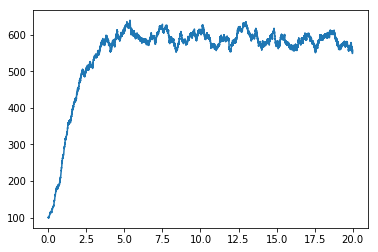

In [102]:
#G = nx.configuration_model([1,5,10]*100000)
G = nx.erdos_renyi_graph(1000, 0.05)
initial_size = 100
gamma = 1.
tau = 0.05
t, S, I = Gillespie_SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))

plt.plot(t, I)

In [95]:
def get_stability_time(inf_arr, num_steps, interval, eps, threshold):
    count = 0
    stab_time = num_steps
    for i, j in zip(np.arange(0, num_steps - interval, 1), np.arange(interval, num_steps, 1)):
        if abs(inf_arr[j] - inf_arr[i]) < eps:
            count += 1
        else:
            count = 0
        if count > threshold:
            stab_time = i
            break
    return stab_time        

In [108]:
stab_time = get_stability_time(I, len(t), 100, 0.1, 5)
t[stab_time - 1]

2.8424202300647026

## Пример 2

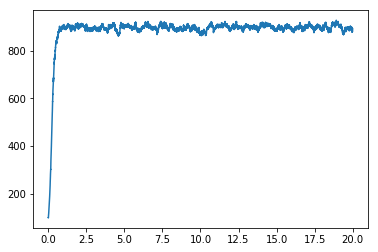

In [109]:
#G = nx.configuration_model([1,5,10]*100000)
G = nx.erdos_renyi_graph(1000, 0.05)
initial_size = 100
gamma = 1.
tau = 0.2
t, S, I = Gillespie_SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))

plt.plot(t, I)

In [112]:
stab_time = get_stability_time(I, len(t), 100, 0.1, 5)
t[stab_time - 1]

1.2863774773504808

## Ансабль из 100 сетей

In [88]:
network_arr = np.arange(100)
N = 1000
p = 0.05
G_ensemble = []
for _ in network_arr:
    G_ensemble.append(nx.erdos_renyi_graph(N, p))

### Построим зависимость времени стабилизации от вероятности заражения

In [135]:
p_inf_arr = np.linspace(0.01, 0.2, 10)
p_inf_arr

array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ])

In [136]:
initial_size = 100
gamma = 1.
t_stab = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    for g in G_ensemble:
        t, S, I = Gillespie_SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        inf_array.append(I.tolist())
        
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len:
            last_elem = arr[-1]
            for j in range(max_len - len(arr)):
                arr.append(last_elem)
    
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)
    t_stab.append(t[stab_time - 1])

--------------------------------
infection probability:  0.01
--------------------------------
infection probability:  0.03111111111111111
--------------------------------
infection probability:  0.052222222222222225
--------------------------------
infection probability:  0.07333333333333333
--------------------------------
infection probability:  0.09444444444444444
--------------------------------
infection probability:  0.11555555555555555
--------------------------------
infection probability:  0.1366666666666667
--------------------------------
infection probability:  0.1577777777777778
--------------------------------
infection probability:  0.1788888888888889
--------------------------------
infection probability:  0.2


Text(0.5,1,'SIS model on Erdos-Renyu network (ensemble)')

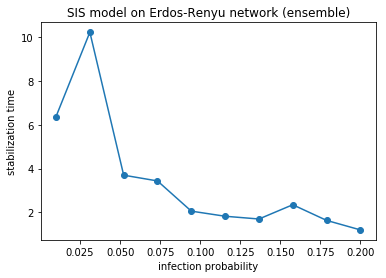

In [138]:
f = plt.figure()
plt.plot(p_inf_arr, t_stab, 'o-')
plt.xlabel('infection probability')
plt.ylabel('stabilization time')
plt.title('SIS model on Erdos-Renyu network (ensemble)')

### Зависимость доли зараженных в момент стабилизации от вероятности заражения

In [218]:
p_inf_arr = np.linspace(0.002, 0.2, 5)
#p_inf_arr = [0.01]

initial_size = 100
gamma = 1.
t_stab = []
t_arr = []
inf_frac = []
std_arr = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    t_array = []
    for g in G_ensemble:
        t, S, I = Gillespie_SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        inf_array.append(I.tolist())
        t_array.append(t.tolist())
    
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len_inf = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_array].index(max([len(arr) for arr in t_array]))
    t_arr.append(t_array[t_max_len])
    
    
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    std = [np.std(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)

    t_stab.append(stab_time)
    inf_frac.append(avrg_inf)
    std_arr.append(std)

--------------------------------
infection probability:  0.002
--------------------------------
infection probability:  0.051500000000000004
--------------------------------
infection probability:  0.101
--------------------------------
infection probability:  0.15050000000000002
--------------------------------
infection probability:  0.2


In [237]:
frac_arr = []
std_at_stab_time = []
for i, arr in enumerate(inf_frac):
    frac_arr.append(arr[t_stab[i]])
    std_at_stab_time.append(std[t_stab[i]])

In [234]:
std_at_stab_time

[6.845027392202313,
 9.511487791087156,
 9.51218166353019,
 9.647776946011966,
 10.610843510296435]

Text(0,0.5,'% of infected')

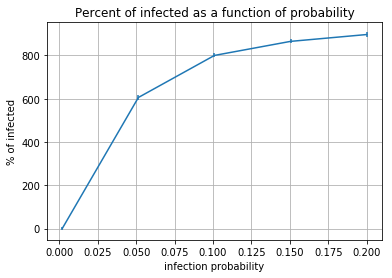

In [243]:
fig, ax = plt.subplots()
ax.errorbar(p_inf_arr, frac_arr, yerr = std_at_stab_time)
ax.grid(True)
ax.set_title('Percent of infected as a function of probability')
ax.set_xlabel('infection probability')
ax.set_ylabel('% of infected')

## Adjacency matrix and eigenvalue

In [140]:
G = nx.erdos_renyi_graph(5000, 0.05)
A = nx.adjacency_matrix(G)
A = A.todense()
max_eigval = max(LA.eigvalsh(A))

In [141]:
max_eigval

250.6300663744437

Epidemic threshold $\tau = \frac{1}{250} = 0.004$

In [154]:
tau_arr = np.linspace(0.0001, 0.01, 10)
tau_arr

array([0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078,
       0.0089, 0.01  ])

In [156]:
initial_size = 100
gamma = 1.
tau = 0.004
I_arr, t_arr = [], []
for tau in (tau_arr):
    t, S, I = Gillespie_SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))
    I_arr.append(I)
    t_arr.append(t)

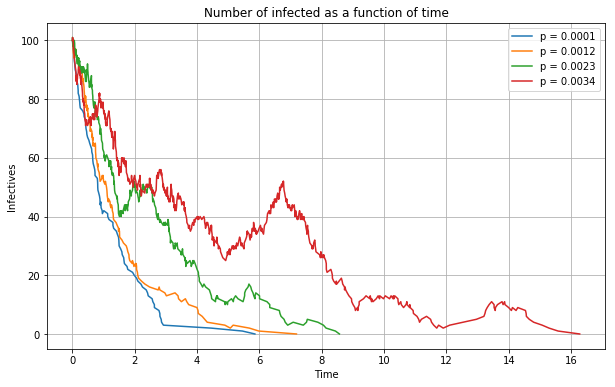

In [191]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_arr[0], I_arr[0], label='p = 0.0001')

ax.plot(t_arr[1], I_arr[1], label='p = 0.0012')

ax.plot(t_arr[2], I_arr[2], label='p = 0.0023')

ax.plot(t_arr[3], I_arr[3], label='p = 0.0034')

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

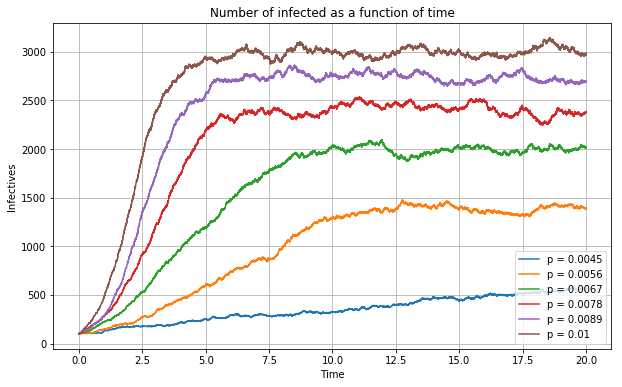

In [192]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_arr[4], I_arr[4], label='p = 0.0045')

ax.plot(t_arr[5], I_arr[5], label='p = 0.0056')

ax.plot(t_arr[6], I_arr[6], label='p = 0.0067')

ax.plot(t_arr[7], I_arr[7], label='p = 0.0078')

ax.plot(t_arr[8], I_arr[8], label='p = 0.0089')

ax.plot(t_arr[9], I_arr[9], label='p = 0.01')

ax.legend(loc='lower right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()


## Barabashi-Albert

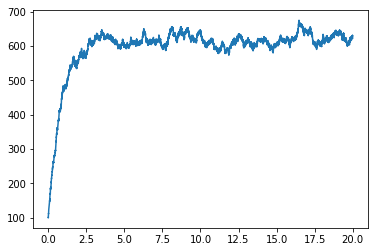

In [288]:
G = nx.barabasi_albert_graph(1000, 5)
initial_size = 100
gamma = 1.
tau = 0.3
t, S, I = Gillespie_SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))

plt.plot(t, I)

In [278]:
network_arr = np.arange(100)
G_ensemble = []
for _ in network_arr:
    G_ensemble.append(nx.barabasi_albert_graph(1000, 5))

In [289]:
p_inf_arr = np.linspace(0.05, 0.5, 10)
p_inf_arr

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [290]:
initial_size = 100
gamma = 1.
t_stab = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    for g in G_ensemble:
        t, S, I = Gillespie_SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        inf_array.append(I.tolist())
        
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len:
            last_elem = arr[-1]
            for j in range(max_len - len(arr)):
                arr.append(last_elem)
    
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)
    t_stab.append(t[stab_time - 1])

--------------------------------
infection probability:  0.05
--------------------------------
infection probability:  0.1
--------------------------------
infection probability:  0.15000000000000002
--------------------------------
infection probability:  0.2
--------------------------------
infection probability:  0.25
--------------------------------
infection probability:  0.3
--------------------------------
infection probability:  0.35000000000000003
--------------------------------
infection probability:  0.4
--------------------------------
infection probability:  0.45
--------------------------------
infection probability:  0.5


Text(0.5,1,'SIS model on Barabashi-Albert network (ensemble)')

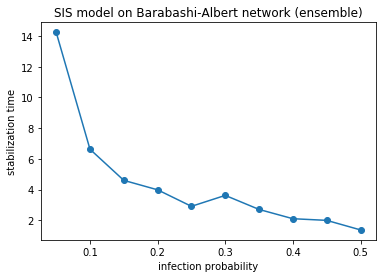

In [299]:
f = plt.figure()
plt.plot(p_inf_arr, t_stab, 'o-')
plt.xlabel('infection probability')
plt.ylabel('stabilization time')
plt.title('SIS model on Barabashi-Albert network (ensemble)')

In [300]:
p_inf_arr = np.linspace(0.02, 0.4, 5)
#p_inf_arr = [0.01]

initial_size = 100
gamma = 1.
t_stab = []
t_arr = []
inf_frac = []
std_arr = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    t_array = []
    for g in G_ensemble:
        t, S, I = Gillespie_SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        inf_array.append(I.tolist())
        t_array.append(t.tolist())
    
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len_inf = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_array].index(max([len(arr) for arr in t_array]))
    t_arr.append(t_array[t_max_len])
    
    
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    std = [np.std(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)

    t_stab.append(stab_time)
    inf_frac.append(avrg_inf)
    std_arr.append(std)

--------------------------------
infection probability:  0.02
--------------------------------
infection probability:  0.115
--------------------------------
infection probability:  0.21
--------------------------------
infection probability:  0.30500000000000005
--------------------------------
infection probability:  0.4


In [301]:
frac_arr = []
std_at_stab_time = []
for i, arr in enumerate(inf_frac):
    frac_arr.append(arr[t_stab[i]])
    std_at_stab_time.append(std[t_stab[i]])

Text(0,0.5,'% of infected')

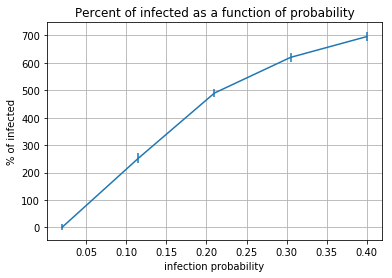

In [302]:
fig, ax = plt.subplots()
ax.errorbar(p_inf_arr, frac_arr, yerr = std_at_stab_time)
ax.grid(True)
ax.set_title('Percent of infected as a function of probability')
ax.set_xlabel('infection probability')
ax.set_ylabel('% of infected')

## Matrix adjacency

In [260]:
A = nx.adjacency_matrix(G)
A = A.todense()
max_eigval = max(LA.eigvalsh(A))

In [261]:
max_eigval

20.166362460499315

Epidemic threshold $\tau = \frac{1}{20} = 0.05$